# Analyzing download speeds in South-Holland municipalities using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to South-Holland municipalities
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [2]:
pip install geopandas

     |████████████████████████████████| 1.1 MB 467 kB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 8.5 MB 5.6 MB/s eta 0:00:011
     |████████████████████████████████| 18.6 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 4.5 MB/s eta 0:00:01
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point
from adjustText import adjust_text

---

## Download data

First, download the data using the link below

In [3]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_{service_type}_tiles.zip"
    return url

In [4]:
tile_url = get_tile_url("fixed", 2020, 2)
tile_url

'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2020/quarter%3D2/2020-04-01_performance_fixed_tiles.zip'

In [5]:
tiles = gp.read_file(tile_url)

In [6]:
tiles.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


---

## Get county boundaries

Then, I’ll load the Kentucky county boundaries from the U.S. Census Bureau ftp site.

In [17]:
# zipfile of U.S. county boundaries
county_url = "https://stacks.stanford.edu/file/druid:gp502yc4422/data.zip"
# county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" 
counties = gp.read_file(county_url)

In [18]:
counties.head()

,ID_0,ISO,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,NAME_VARIA,NAME_NONLA,NAME_FRENC,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,158,NLD,Netherlands,NETHERLANDS,Netherlands,Nederland,NaN,Holland|The Netherlands|Netherlands,NaN,Pays-Bas,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((3.51528 51.40736, 3.51528 51.4..."


In [8]:
# zipfile of the Second-level Administrative Divisions, Netherlands, 2015
NL_url = "https://stacks.stanford.edu/file/druid:sq928md5963/data.zip" 
municipalities = gp.read_file(NL_url)
municipalities.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,158,NLD,Netherlands,1,Drenthe,1,Aa en Hunze,NL.DR.AH,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((6.94647 52.99362, 6.93894 52.99192, ..."
1,158,NLD,Netherlands,1,Drenthe,2,Assen,NL.DR.AS,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((6.56990 52.94651, 6.56099 52.95111, ..."
2,158,NLD,Netherlands,1,Drenthe,3,Borger-Odoorn,NL.DR.BO,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((7.02172 52.87205, 7.02045 52.87212, ..."
3,158,NLD,Netherlands,1,Drenthe,4,Coevorden,NL.DR.CO,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((6.87156 52.65302, 6.87122 52.65298, ..."
4,158,NLD,Netherlands,1,Drenthe,5,De Wolden,NL.DR.DW,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((6.53873 52.65509, 6.53849 52.65496, ..."


In [18]:
municipalities.NAME_1.unique()

array(['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Groningen',
       'IJsselmeer', 'Limburg', 'Noord-Brabant', 'Noord-Holland',
       'Overijssel', 'Utrecht', 'Zeeland', 'Zeeuwse meren',
       'Zuid-Holland'], dtype=object)

In [30]:
# filter out the Kentucky fips code and reproject to match the tiles
rotterdam_municipalities = municipalities.loc[municipalities['NAME_1'] == 'Zuid-Holland'].to_crs(4326) 

In [31]:
rotterdam_municipalities

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
400,158,NLD,Netherlands,14,Zuid-Holland,401,'s-Gravendeel,NL.ZH.SD,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((4.63009 51.72888, 4.62717 51.72976, ..."
401,158,NLD,Netherlands,14,Zuid-Holland,402,'s-Gravenhage,NaN,0,NaN,Gemeente,Municipality,NaN,NaN,"MULTIPOLYGON (((4.19828 52.05431, 4.19917 52.0..."
402,158,NLD,Netherlands,14,Zuid-Holland,403,'s-Gravenzande,NL.ZH.SZ,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((4.18035 52.00945, 4.17894 52.00849, ..."
403,158,NLD,Netherlands,14,Zuid-Holland,404,Alblasserdam,NL.ZH.AS,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((4.68618 51.84866, 4.68473 51.84865, ..."
404,158,NLD,Netherlands,14,Zuid-Holland,405,Albrandswaard,NL.ZH.AW,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((4.45194 51.83253, 4.43436 51.83686, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,158,NLD,Netherlands,14,Zuid-Holland,487,Zederik,NL.ZH.ZE,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((5.10653 51.94671, 5.10364 51.94311, ..."
487,158,NLD,Netherlands,14,Zuid-Holland,488,Zevenhuizen-Moerkapelle,NL.ZH.ZM,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((4.61928 51.99901, 4.60393 51.98936, ..."
488,158,NLD,Netherlands,14,Zuid-Holland,489,Zoetermeer,NL.ZH.ZR,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((4.55955 52.06141, 4.55110 52.05432, ..."
489,158,NLD,Netherlands,14,Zuid-Holland,490,Zoeterwoude,NL.ZH.ZD,0,NaN,Gemeente,Municipality,NaN,NaN,"POLYGON ((4.53282 52.08006, 4.52245 52.08536, ..."


---

## Join tiles to counties

Now I’ll join the tiles to the counties. I use how = "inner" because I only want to include counties that have at least 1 tile.

In [32]:
tiles_in_rotterdam_municipalities = gp.sjoin(tiles, rotterdam_municipalities, how="inner", predicate='intersects')

In [33]:
# convert to Mbps for easier reading
tiles_in_rotterdam_municipalities['avg_d_mbps'] = tiles_in_rotterdam_municipalities['avg_d_kbps'] / 1000
tiles_in_rotterdam_municipalities['avg_u_mbps'] = tiles_in_rotterdam_municipalities['avg_u_kbps'] / 1000

In [34]:
tiles_in_rotterdam_municipalities.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry,index_right,ID_0,ISO,...,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,avg_d_mbps,avg_u_mbps
587,1202021102230001,77100,27714,14,74,13,"POLYGON ((4.31213 52.10651, 4.31763 52.10651, ...",401,158,NLD,...,'s-Gravenhage,NaN,0,NaN,Gemeente,Municipality,NaN,NaN,77.100,27.714
4472,1202021120000031,120307,26809,13,149,22,"POLYGON ((4.23523 52.04573, 4.24072 52.04573, ...",401,158,NLD,...,'s-Gravenhage,NaN,0,NaN,Gemeente,Municipality,NaN,NaN,120.307,26.809
8402,1202021120001012,86740,33564,9,273,38,"POLYGON ((4.27368 52.04911, 4.27917 52.04911, ...",401,158,NLD,...,'s-Gravenhage,NaN,0,NaN,Gemeente,Municipality,NaN,NaN,86.740,33.564
9299,1202021102223201,120047,21499,11,183,46,"POLYGON ((4.26819 52.06600, 4.27368 52.06600, ...",401,158,NLD,...,'s-Gravenhage,NaN,0,NaN,Gemeente,Municipality,NaN,NaN,120.047,21.499
12200,1202021120011230,143187,88231,10,41,20,"POLYGON ((4.36157 52.03222, 4.36707 52.03222, ...",401,158,NLD,...,'s-Gravenhage,NaN,0,NaN,Gemeente,Municipality,NaN,NaN,143.187,88.231


---

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [39]:
# def weighted_mean(group, avg_name, weight_name):
#     """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
#     In rare instance, we may not have weights, so just return the mean. Customize this if your business case
#     should return otherwise.
#     """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return d.mean()
    
county_stats = (
    tiles_in_rotterdam_municipalities.groupby(["ID_2", "NAME_2"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_rotterdam_municipalities.groupby(["ID_2", "NAME_2"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["ID_2", "NAME_2"],
    )
)

In [40]:
table_stats = (
    county_stats.loc[county_stats["tests"] >= 50]
    .nlargest(20, "avg_d_mbps_wt")
    .append(
        county_stats.loc[county_stats["tests"] >= 50].nsmallest(20, "avg_d_mbps_wt")
    )
    .sort_values("avg_d_mbps_wt", ascending=False)
    .round(2) # round to 2 decimal places for easier reading
)

In [41]:
header = ["ID_2", "Municipality", "Avg download speed (Mbps)", "Tests"]

table_stats.rename(columns=dict(zip(table_stats.columns, header)))

,ID_2,Municipality,Avg download speed (Mbps),Tests
67,468,Rozenburg,125.81,1556
6,407,Alphen aan den Rijn,122.47,11049
22,423,Dordrecht,119.65,15822
10,411,Berkel en Rodenrijs,118.92,5736
44,445,Maassluis,117.97,4217
69,470,Schiedam,117.39,11500
4,405,Albrandswaard,113.88,6340
73,474,Spijkenisse,112.42,9946
1,402,'s-Gravenhage,110.73,74242
84,485,Wateringen,110.57,4935


---

## Map the counties

The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

One thing that helps people orient themselves on a map is including major place names. The [census FTP site](ftp://ftp2.census.gov/geo/tiger/) makes it fairly easy to get a quick list!

In [42]:
county_data = rotterdam_municipalities[['ID_2', 'geometry']].merge(county_stats, on='ID_2').to_crs(26916)

In [43]:
labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(
    county_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

In [18]:
# # add place labels 
# ky_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_21_place.zip")

In [19]:
# ky_places = ky_places.loc[ky_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
# ky_places["centroid"] = ky_places["geometry"].centroid
# ky_places.set_geometry("centroid", inplace = True)

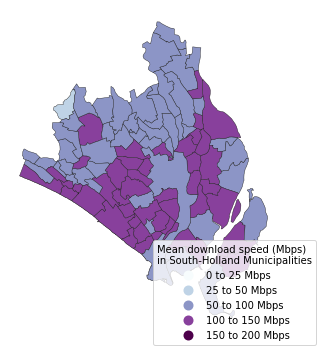

In [44]:
fig, ax = plt.subplots(1, figsize=(16, 6))

county_data.plot(
    column="group", cmap="BuPu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.3))
leg.set_title("Mean download speed (Mbps)\nin South-Holland Municipalities")

# texts = []
# for x, y, label in zip(ky_places.geometry.x, ky_places.geometry.y, ky_places["NAME"]):
#     texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

# adjust_text(
#     texts,
#     force_points=0.3,
#     force_text=0.8,
#     expand_points=(1, 1),
#     expand_text=(1, 1),
#     arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
# )